# **Sentiment Analysis for a Movie Review**

# **Importing the necessary Libraries**


In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import scipy.stats as stats
import scipy.stats as uniform
from sklearn.utils.multiclass import type_of_target
#from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import f1_score,precision_score,precision_recall_curve,recall_score,mean_squared_error,accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer,LabelEncoder, StandardScaler ,OrdinalEncoder,FunctionTransformer,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Loading the train, test and movie DataSet from the CSV file

In [68]:
#read the train.csv file 
df_train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
#read the test.csv file 
df_test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
#read the movies.csv file
df_movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

# Shape of the Movie.csv, train.csv and test.csv

In [69]:
print(df_movies.shape, df_train.shape, df_test.shape)

(143258, 14) (162758, 5) (55315, 4)


# Target Type

In [70]:
type_of_target(df_train['sentiment'])


'binary'

'POSITIVE' and 'Negative'are the unique values of the target

In [71]:
df_train['sentiment'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

# Visualization of the target data

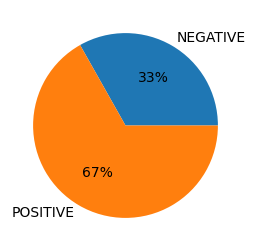

In [72]:
unique, counts = np.unique(df_train['sentiment'], return_counts=True)
plt.figure(figsize=(3,3))
plt.pie(counts, labels=unique, autopct='%.0f%%');

Note: Here datapoints 'POSITIVE' class is significantly higher than in the 'NEGATIVE' class.This class distribution signifies an imbalanced dataset.

# Data Preprocessing

In [73]:
df_train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [74]:
df_test.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [75]:

df_movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [76]:
df_movies.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


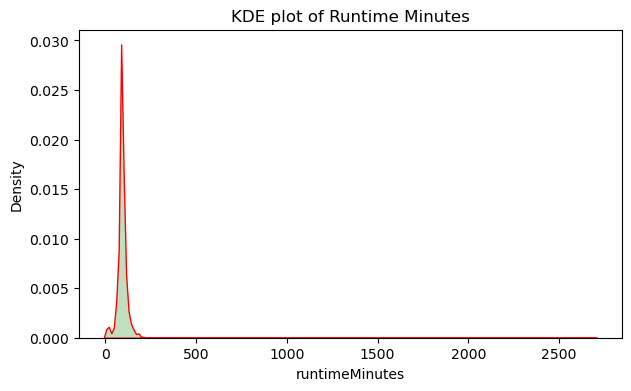

In [77]:
# visualizing the distribution of Runtime Minutes in a dataset
plt.figure(figsize=(7,4))
sns.kdeplot(data=df_movies['runtimeMinutes'], fill=True, color='green', edgecolor='red')
plt.title('KDE plot of Runtime Minutes')
plt.ylabel('Runtime Minutes')
plt.ylabel('Density')
plt.show()

In [78]:
df_movies.head()


,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


# Preprocessing the test dataset

In [79]:
df_test.describe()

,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


In [80]:
df_test.rename(columns={'isTopCritic': 'isFrequentReviewer'},inplace=True)

In [81]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieid             55315 non-null  object
 1   reviewerName        55315 non-null  object
 2   isFrequentReviewer  55315 non-null  bool  
 3   reviewText          52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


# Preprocessing the movies dataset

In [82]:
df_movies.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [83]:
df_movies.columns

Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType'],
      dtype='object')

# Checking for null values more than 60% 

In [84]:
df_movies.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [85]:
null_values = pd.DataFrame(df_movies.isnull().sum())

In [86]:
null_values.rename(columns={0:'null_values'}, inplace = True)

In [87]:
null_values['null_values']=(null_values['null_values']/df_movies.shape[0])*100

In [88]:
null_values

,null_values
movieid,0.000000
title,0.000000
audienceScore,48.869871
rating,90.233704
ratingContents,90.233704
releaseDateTheaters,78.519175
releaseDateStreaming,44.561560
runtimeMinutes,9.651817
genre,7.736392
originalLanguage,9.673456


In [89]:
df_movies.shape[0]

143258

<Axes: >

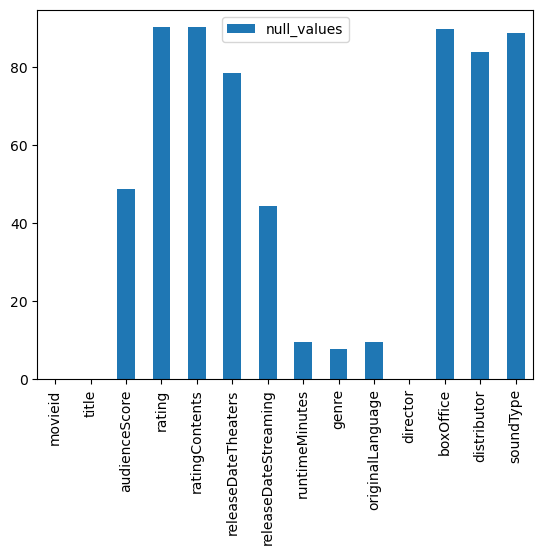

In [90]:
null_values.plot(kind='bar')

In [91]:
# Calculate the percentage of null values in each column
null_percentage = (df_movies.isnull().sum() / len(df_movies)) * 100
columns_with_high_nulls = null_percentage[null_percentage > 60].index
print(columns_with_high_nulls)

Index(['rating', 'ratingContents', 'releaseDateTheaters', 'boxOffice',
       'distributor', 'soundType'],
      dtype='object')


In [92]:
len(df_movies['movieid'])

143258

In [93]:
unique_movie_ids = df_movies['movieid'].nunique()
unique_movie_ids

126404

In [94]:
med_audscore_permovie = df_movies.groupby('movieid')['audienceScore'].median().reset_index()
df_movies = df_movies.drop(columns=['title', 'rating', 'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming',
                   'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor', 'soundType'])


In [95]:
df_movies = pd.merge(df_movies, med_audscore_permovie, on='movieid', how='left', suffixes=('', 'new'))


In [96]:
del df_movies['audienceScore']

In [97]:
df_movies.head(10)

,movieid,runtimeMinutes,audienceScorenew
0,han_solo_heroic_myth_wonder_woman,75.0,50.0
1,voyage_tyler_durden_han_solo_stardust,114.0,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,120.0,43.0
3,elegant_hermione_granger,90.0,60.0
4,adventure_rocky_balboa,80.0,26.0
5,james_bond_courageous,120.0,62.0
6,rocky_balboa_elegant_jack_sparrow,88.0,55.0
7,evoke_darth_vader_marty_mcfly,NaN,88.0
8,jon_snow_e.t.,123.0,NaN
9,glorious_quench_iron_man,92.0,74.0


In [98]:

df_movies.rename(columns={'audienceScorenew':'audienceScore'}, inplace=True)
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143258 entries, 0 to 143257
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movieid         143258 non-null  object 
 1   runtimeMinutes  129431 non-null  float64
 2   audienceScore   80552 non-null   float64
dtypes: float64(2), object(1)
memory usage: 4.4+ MB


# Distribution of the Audience Score

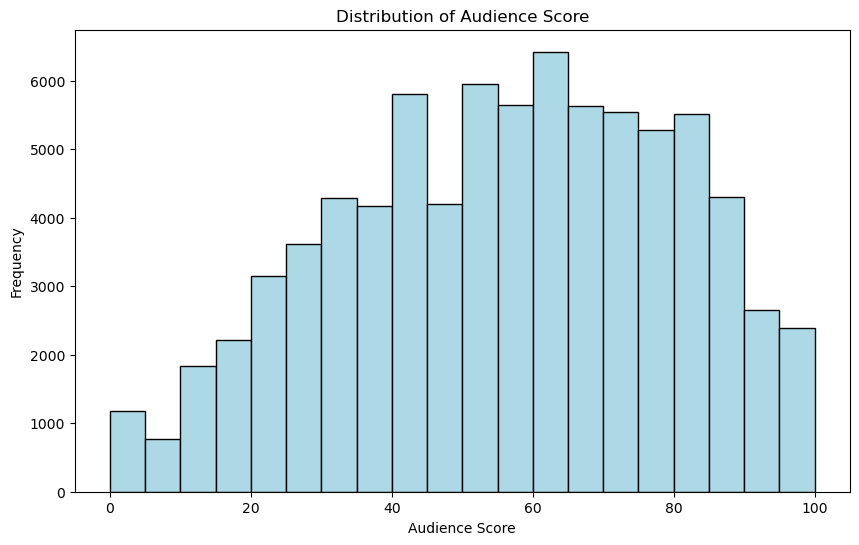

In [99]:
plt.figure(figsize=(10, 6))
plt.hist(df_movies['audienceScore'], bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Audience Score')
plt.ylabel('Frequency')
plt.title('Distribution of Audience Score')
plt.show()

# Merging  training and testing dataset with movie dataset

In [100]:
df_train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE
...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE


In [101]:
df_movies=df_movies.dropna(subset=['audienceScore'])
df_movies=df_movies.drop_duplicates(subset=['movieid'],keep='first')

In [102]:
merge_train=pd.merge(df_train,df_movies,on='movieid',how='left')
merge_train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,runtimeMinutes,audienceScore
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,105.0,65.0
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,91.0,47.0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,130.0,80.0
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,15.0,32.0
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,131.0,97.0
...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE,96.0,43.0
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE,102.0,20.0
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE,90.0,78.0
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE,88.0,39.0


# Correlations matrix 

To understand the relationships and potential dependencies between the training dataset.

In [103]:
corr =merge_train.corr(numeric_only=True)
print(corr)

                    isFrequentReviewer  runtimeMinutes  audienceScore
isFrequentReviewer            1.000000       -0.032217      -0.024994
runtimeMinutes               -0.032217        1.000000       0.226000
audienceScore                -0.024994        0.226000       1.000000


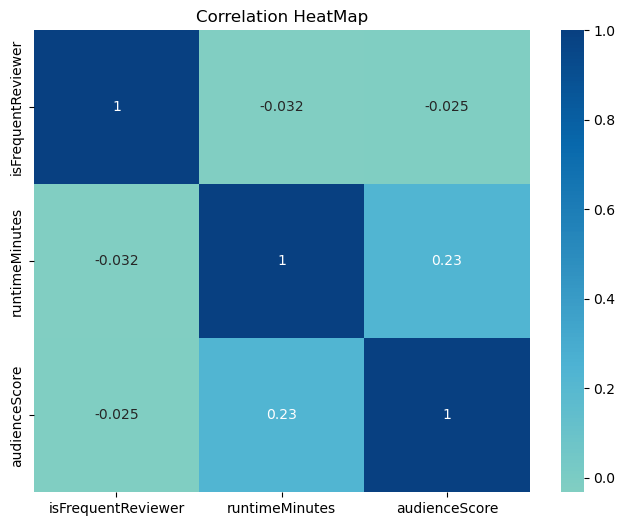

In [104]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='GnBu', center=0)
plt.title('Correlation HeatMap')
plt.show()

In [105]:
#Note:There's a small negative correlation (-0.032217) between "runtimeMinutes" and "isFrequentReviewer".
     #This suggests a very weak inverse relationship, implying that longer runtime movies might be 
    #slightly less likely to be reviewed by frequent reviewers.
    
    #There's a positive correlation (0.226000) between "runtimeMinutes" and "audienceScore".
    #This indicates that there's a weak positive relationship between movie runtime and audience score,
    #meaning that longer movies might slightly tend to have higher audience scores.
    
    #There's a small negative correlation (-0.024994) between "audienceScore" and "isFrequentReviewer".
    #This implies a very weak inverse relationship, suggesting that movies with higher audience scores 
    #might be slightly less likely to be reviewed by frequent reviewers.
    
    #There's a positive correlation (0.226000) between "audienceScore" and "runtimeMinutes".
    #This mirrors the observation from earlier: longer movies might have slightly higher audience scores.


In [106]:
merge_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             162758 non-null  object 
 1   reviewerName        162758 non-null  object 
 2   isFrequentReviewer  162758 non-null  bool   
 3   reviewText          156311 non-null  object 
 4   sentiment           162758 non-null  object 
 5   runtimeMinutes      157466 non-null  float64
 6   audienceScore       159922 non-null  float64
dtypes: bool(1), float64(2), object(4)
memory usage: 8.8+ MB


In [107]:
merge_test=pd.merge(df_test,df_movies,on='movieid',how='left')
merge_test

,movieid,reviewerName,isFrequentReviewer,reviewText,runtimeMinutes,audienceScore
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...,111.0,57.0
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...,94.0,86.0
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...,NaN,62.0
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...,92.0,70.0
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...,NaN,NaN
...,...,...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,Ron Howard delivers an unconventional romantic...,111.0,29.0
55311,vivid_james_t._kirk,Thomas Osborne,False,As an oddball art film that openly invites you...,116.0,71.0
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,Nicholson wears his devilish grin from his fir...,106.0,60.0
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,It's hard not be entertained by two dozen of C...,125.0,65.0


# Filling the null values of audienceScore with mean value and reviewText with an empty string

In [108]:
mean_train_sc = merge_train['audienceScore'].mean()
mean_test_sc = merge_test['audienceScore'].mean()

# Fill NaN values in 'audienceScore' column with the mean
merge_train['audienceScore'].fillna(mean_train_sc, inplace=True)
merge_test['audienceScore'].fillna(mean_test_sc, inplace=True)

# Fill NaN values in 'reviewText' column with an empty string
merge_train['reviewText'].fillna('', inplace=True)
merge_test['reviewText'].fillna('', inplace=True)

merge_train.isna().sum()


movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText               0
sentiment                0
runtimeMinutes        5292
audienceScore            0
dtype: int64

In [109]:
merge_train=merge_train.drop(columns=['reviewerName','isFrequentReviewer','runtimeMinutes'])
merge_test=merge_test.drop(columns=['reviewerName','isFrequentReviewer','runtimeMinutes'])


In [110]:
merge_train.isna().sum()

movieid          0
reviewText       0
sentiment        0
audienceScore    0
dtype: int64

In [111]:
print(df_train.shape,merge_train.shape, df_test.shape, merge_test.shape)

(162758, 5) (162758, 4) (55315, 4) (55315, 3)


# Preprocessing the Categorical data

In [112]:
def process_cat1(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ',',text)
    text = re.sub(r'\b\w*\d\w*\b', '',text)
    return text

In [113]:
def process_cat2(text):
    text = re.sub(r"['\"]", '', text)
    text = re.sub(r'\n', '', text)
    return text

In [114]:
def process_cat3(text):
    text = process_cat1(text)
    text = process_cat2(text)
    text = re.sub(r'\d+', '', text) # Remove numeric digits
    text = re.sub(r'http\S+|https\S+|\S+@\S+', '', text) # Remove URLs, emails
    text = re.sub(r'[^a-zA-Z\s]', '', text)# Remove special characters
    text = re.sub(r':\)|:\(|<3', '', text)# Convert emojis    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)# Remove non-alphanumeric characters and extra space
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space       
    stopwords = set(['and','the', 'is', 'it', 'its,''in', 'of', 'to', 'was', 'there'])# Remove stopwords
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]  # Fixed the list comprehension syntax
    text = ' '.join(filtered_tokens) 
    text = text.lower()# Convert to lowercase
    return text

In [115]:
merge_train['reviewText'] = merge_train['reviewText'].apply(process_cat3)
merge_test['reviewText'] = merge_test['reviewText'].apply(process_cat3)
                                                          

# Converting cateogical to numerical using Countvectorizer

In [116]:
# tf_review = TfidfVectorizer(max_features=7200,min_df=20,lowercase=True, ngram_range=(1, 2),strip_accents='unicode')
# tf_review.fit(list(df_train.reviewText))
# X_tf_review_train =  tf_review.transform(df_train.reviewText)
# X_tf_review_train
count_vec = CountVectorizer(lowercase=True, ngram_range=(1, 3))
tf_train = count_vec.fit_transform(merge_train['reviewText'])
tf_test = count_vec.transform(merge_test['reviewText'])


In [117]:
target = merge_train['sentiment'].replace({"POSITIVE": 1, "NEGATIVE": 0})
train_col = merge_train.drop(columns=['sentiment'])
test_col = merge_test

In [118]:
print(train_col.columns)

Index(['movieid', 'reviewText', 'audienceScore'], dtype='object')


In [119]:
print(test_col.columns)

Index(['movieid', 'reviewText', 'audienceScore'], dtype='object')


In [120]:
print(train_col.shape,test_col.shape)

(162758, 3) (55315, 3)


# Data Transformation

In [121]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
     ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# feature_union = FeatureUnion([
#     ('num', numerical_pipe),
#     ('cat', categorical_pipe),
#     ('tfidf', count_vec)
# ])


In [122]:
train_col.head()

,movieid,reviewText,audienceScore
0,marvelous_pirate,henry selicks first movie since s coraline his...,65.0
1,tony_montana_frodo_baggins_v_rocky_balboa,with a cast that reads like vogue oscar party ...,47.0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,creed ii does not give us anything but another...,80.0
3,lara_croft_glimmer,i know what youre thinking but this no limitle...,32.0
4,jason_bourne_surreal_the_terminator_indiana_jones,director fernando meirelles tells story with u...,97.0


In [123]:
# Transform training and test data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipe, ['audienceScore']),
        ('cat', categorical_pipe, ['movieid']),
        ('tfidf', count_vec, 'reviewText')
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)


In [124]:
trans_train = preprocessor.fit_transform(train_col)
trans_test = preprocessor.transform(test_col)

In [125]:
print(trans_train.shape,trans_test.shape)

(162758, 3308994) (55315, 3308994)


# Train Test Split

In [126]:
# # Splitting the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(trans_train, target, test_size=0.2, random_state=42, shuffle=True)

# Model Training

In [127]:
#logistic regression model
# model = LogisticRegression()
# model.fit(X_train, y_train)
# Training Accuracy: 0.6674423605671014
# Validation Accuracy: 0.6714180388301794
# Training Precision: 0.6674423605671014
# Training Recall: 0.932340775988287
# Training F1-score: 0.8005582397943909
# Validation Precision: 0.6714180388301794
# Validation Recall: 1.0
# Validation F1-score: 0.8034112630495515

In [ ]:
# #LinearSVC model
# model = LinearSVC(random_state=1, max_iter=5000)
# model.fit(X_train, y_train)
# Training Accuracy: 0.7855705574243891
# Validation Accuracy: 0.7656672401081347
# Training Precision: 0.7996383106261493
# Training Recall: 0.905655600943559
# Training F1-score: 0.8493514341829798
# Validation Precision: 0.7887175324675325
# Validation Recall: 0.8891837481698389
# Validation F1-score: 0.835942876806607


In [ ]:
# #multinomialNB
# model = MultinomialNB()
# model.fit(X_train, y_train)
# Training Accuracy: 0.8229113865720473
# Validation Accuracy: 0.6720324404030474
# Training Precision: 0.7928412207718345
# Training Recall: 0.9945342615499684
# Training F1-score: 0.8823079043273205
# Validation Precision: 0.7079148999479283
# Validation Recall: 0.870836383601757
# Validation F1-score: 0.7809691846867179
# Accuracy in test data: 0.69021 

In [128]:
model = BaggingClassifier(
        base_estimator = LogisticRegression(penalty='l1',C=8, solver='liblinear',max_iter=300,random_state=42), 
        n_estimators=30)
model.fit(X_train, y_train)

# Training Accuracy: 0.9819439964364162
# Validation Accuracy: 0.8221000245760629
# Training Precision: 0.9809560647084253
# Training Recall: 0.9922098843564812
# Training F1-score: 0.986550881829675
# Validation Precision: 0.8501373087485289
# Validation Recall: 0.892340775988287
# Validation F1-score: 0.8707279505324016

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=LogisticRegression(C=8, max_iter=300,
                                                    penalty='l1',
                                                    random_state=42,
                                                    solver='liblinear'),
                  n_estimators=30)

# Hyperparameter Tuning

In [ ]:
# # Define the hyperparameter distributions
# param_dict = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet'],
#     'solver': ['newton-cg', 'sag', 'saga'],
#     'max_iter': [3000,5000,8000,10000,15000]
# }

# # Create a LogisticRegression model
# model = LogisticRegression()

# # Perform randomized search with cross-validation
# random_search = RandomizedSearchCV(
#     model, param_distributions=param_dict, n_iter=10, cv=5, n_jobs=-1, verbose=2
# )
# random_search.fit(X_train, y_train)

# # Get the best hyperparameters and corresponding model
# random_search.best_params_


# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# [CV] END C=100, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=1, max_iter=8000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=1, max_iter=8000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=10, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=0.01, max_iter=3000, penalty=l1, solver=newton-cg; total time=   0.1s
# [CV] END C=1, max_iter=5000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END ..C=0.001, max_iter=15000, penalty=l1, solver=saga; total time=105.2min
# [CV] END C=0.1, max_iter=3000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END C=0.1, max_iter=3000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END C=0.1, max_iter=3000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END C=0.1, max_iter=3000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END C=0.1, max_iter=3000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END ...C=1, max_iter=5000, penalty=l2, solver=newton-cg; total time= 4.4min
# [CV] END ...C=1, max_iter=5000, penalty=l2, solver=newton-cg; total time= 4.4min
# /opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
#   warnings.warn(
# [CV] END C=100, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=1, max_iter=8000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=10, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.1s
# [CV] END C=0.01, max_iter=3000, penalty=l1, solver=newton-cg; total time=   0.1s
# [CV] END C=0.01, max_iter=3000, penalty=l1, solver=newton-cg; total time=   0.0s
# [CV] END C=1, max_iter=5000, penalty=elasticnet, solver=newton-cg; total time=   0.0s
# [CV] END ..C=0.001, max_iter=15000, penalty=l1, solver=saga; total time=105.3min
# [CV] END ...C=1, max_iter=5000, penalty=l2, solver=newton-cg; total time= 4.6min
# [CV] END ...C=1, max_iter=5000, penalty=l2, solver=newton-cg; total time= 4.3min

In [ ]:

# best_model = LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=15000)
# # Predicting on the training set using the best model
# best_model.fit(X_train, y_train)

# train_predictions = best_model.predict(X_train)

# # Predicting on the validation set using the best model
# val_predictions = best_model.predict(X_val)

# # Calculate precision, recall, and F1-score for training set
# train_precision = precision_score(y_train, train_predictions)
# train_recall = recall_score(y_train, train_predictions)
# train_f1 = f1_score(y_train, train_predictions)

# # Calculate precision, recall, and F1-score for validation set
# val_precision = precision_score(y_val, val_predictions)
# val_recall = recall_score(y_val, val_predictions)
# val_f1 = f1_score(y_val, val_predictions)

# # Calculate confusion matrix for validation set
# confusion_mat = confusion_matrix(y_val, val_predictions)

# print("Training Precision:", train_precision)
# print("Training Recall:", train_recall)
# print("Training F1-score:", train_f1)

# print("Validation Precision:", val_precision)
# print("Validation Recall:", val_recall)
# print("Validation F1-score:", val_f1)

# print("Confusion Matrix:\n", confusion_mat)

# Training Precision: 0.6674423605671014
# Training Recall: 1.0
# Training F1-score: 0.8005582397943909
# Validation Precision: 0.6714180388301794
# Validation Recall: 1.0
# Validation F1-score: 0.8034112630495515
# Confusion Matrix:
#  [[    0 10696]
#  [    0 21856]]

# Model Evaluation and Validations

Training Accuracy: 0.9820745587760933
Validation Accuracy: 0.8221307446547064
Training Precision: 0.9814306695661084
Training Recall: 0.9919107070939531
Training F1-score: 0.9866428595955087
Validation Precision: 0.8511847512459562
Validation Recall: 0.8908308931185944
Validation F1-score: 0.8705566733735749


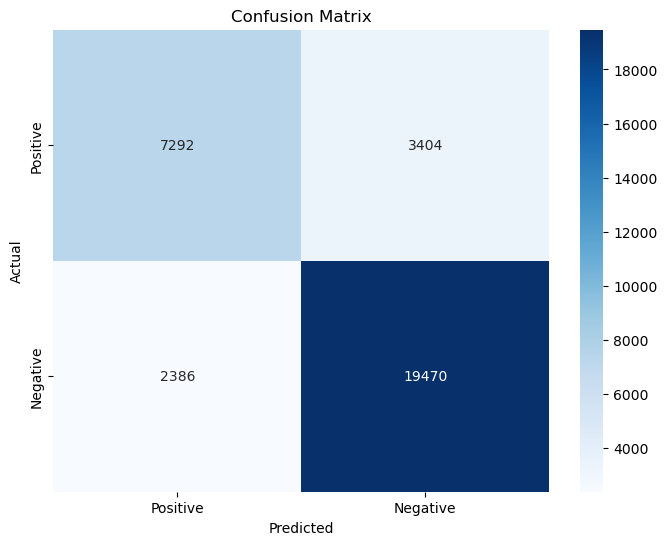

In [129]:

# Predicting on the training set
train_predictions = model.predict(X_train)

# Predicting on the validation set
val_predictions = model.predict(X_val)

# Calculating the training accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

# Calculating the validation accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Calculate precision, recall, and F1-score for training set
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

# Calculate precision, recall, and F1-score for validation set
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)

# Calculate confusion matrix for validation set
confusion_mat = confusion_matrix(y_val, val_predictions)

print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1-score:", train_f1)

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)

# print("Confusion Matrix:\n", confusion_mat)
cm = confusion_matrix(y_val,val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positive','Negative'], yticklabels=['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

In [130]:
report = classification_report(y_val, val_predictions)
report = classification_report(y_val, val_predictions, target_names=['NEGATIVE', 'POSITIVE'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.75      0.68      0.72     10696
    POSITIVE       0.85      0.89      0.87     21856

    accuracy                           0.82     32552
   macro avg       0.80      0.79      0.79     32552
weighted avg       0.82      0.82      0.82     32552



# Comparison of Models

In [ ]:
#Logistic Regression :  Validation Accuracy: 0.7656672401081347
                        #Validation Precision: 0.6714180388301794
                        # Validation Recall: 0.932340775988287
                        # Validation F1-score: 0.8034112630495515
            
#LinearSVC model    :    Validation Accuracy: 0.7656672401081347
                         #Validation Precision: 0.7887175324675325
                        # Validation Recall: 0.8891837481698389
                        # Validation F1-score: 0.835942876806607
            
#multinomialNB     :   Validation Accuracy: 0.6720324404030474
                        #Validation Precision: 0.7079148999479283
                        # Validation Recall: 0.870836383601757
                        # Validation F1-score: 0.7809691846867179
                        
 #BaggingCassifier :    Validation Accuracy: 0.8221000245760629  
                        #Validation Precision: 0.8501373087485289
                        # Validation Recall: 0.892340775988287
                        # Validation F1-score: 0.8707279505324016
                        


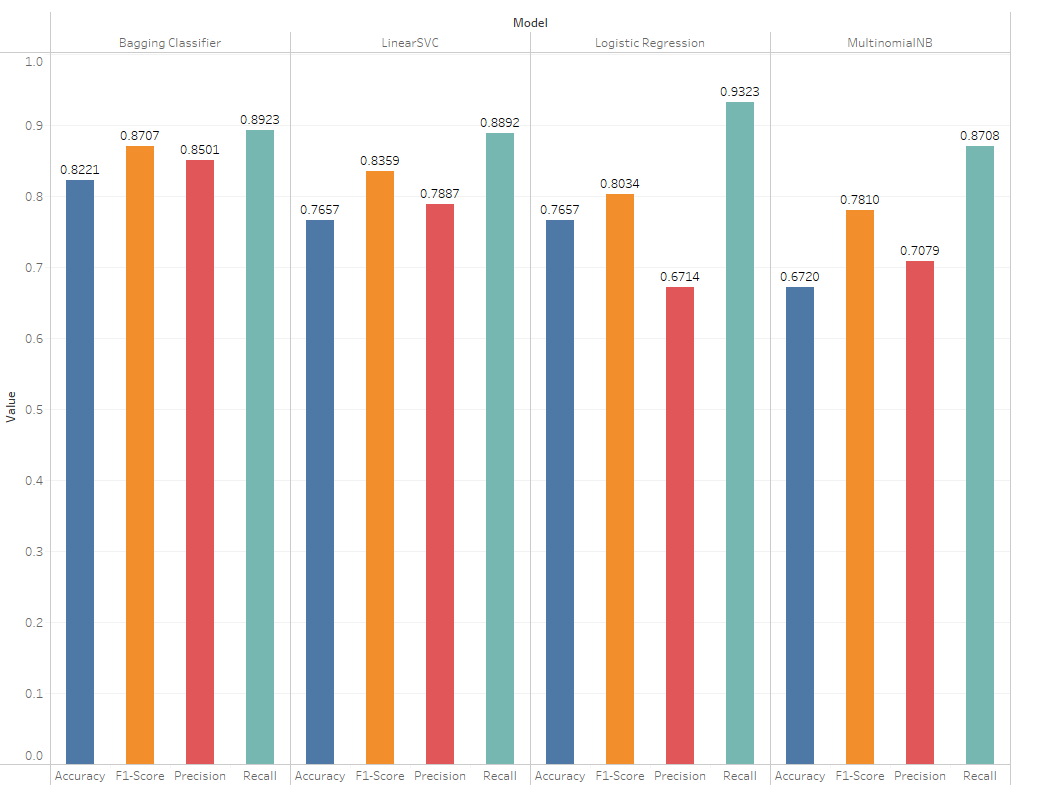


# **Conclusion**



In [ ]:
#Based on comparison,I got the best result with Logistic Regression as a base estimator along with 
#Bagging Classifier,though by seeing the result, model perfoms high on trainin and comparatively less 
#on test data, the model is overfitting.

   


In [ ]:
#from sklearn.dummy import DummyClassifier
#X = df_train["reviewerName"]
#y = df_train["sentiment"]
#dummy_cf = DummyClassifier(strategy="most_frequent")
#dummy_cf.fit(X, y)
#dummy_cf.predict(X)
#sub = pd.DataFrame(dummy_cf.predict(df_test["reviewerName"]), columns=['sentiment'])
#sub.index.name = 'id'
#sub.to_csv("submission.csv", encoding='utf-8')
#output = pd.read_csv("submission.csv")

# Predicting the Accuracy in the test dataset

In [ ]:
# #  best_model = LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=15000)
# #  best_model.fit(X_train, y_train)
# # predection =  best_model.predict(trans_test) 
# predection =  model.predict(trans_test)
# len(predection)
# sample= pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')
# sample.dtypes
# predection = np.where(predection == 1, "POSITIVE", "NEGATIVE")
# predection
    

In [ ]:
# submission  = pd.DataFrame(columns =['id','sentiment'] )
# submission['id'] = [i for i in range(len(predection))]
# submission['sentiment']=predection
# submission.to_csv('submission.csv',index=False)

In [ ]:
# submission